In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import InputLayer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

2024-07-03 20:10:20.114932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### LSTM

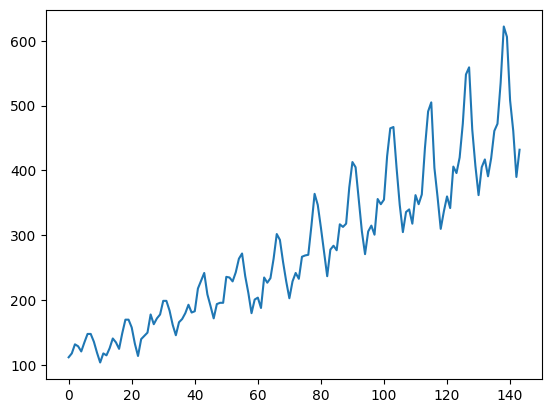

In [2]:
df = pd.read_csv('airline-passengers.csv', usecols=[1])
plt.plot(df)
plt.show()

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# load the dataset
dataset = df.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX[:5]

array([[[0.01544401]],

       [[0.02702703]],

       [[0.05405405]],

       [[0.04826255]],

       [[0.03281853]]], dtype=float32)

In [5]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
94/94 - 2s - loss: 0.0572 - 2s/epoch - 18ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0292 - 113ms/epoch - 1ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0205 - 122ms/epoch - 1ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0180 - 147ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0168 - 133ms/epoch - 1ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0157 - 132ms/epoch - 1ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0148 - 141ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0138 - 124ms/epoch - 1ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0131 - 139ms/epoch - 1ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0122 - 127ms/epoch - 1ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0114 - 133ms/epoch - 1ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0106 - 122ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0098 - 125ms/epoch - 1ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0091 - 120ms/epoch - 1ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0083 - 127ms/epoch - 1ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0077 - 125ms/epoc

Text(0.5, 1.0, 'LSTM')

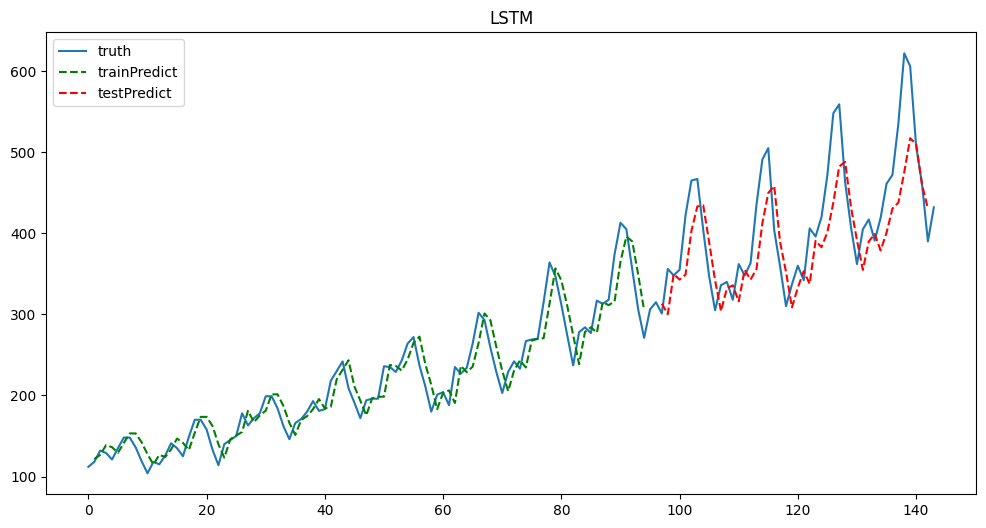

In [6]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(scaler.inverse_transform(dataset), label='truth');
ax.plot(trainPredictPlot, linestyle='--', color='green', label="trainPredict");
ax.plot(testPredictPlot, linestyle='--', color='red', label="testPredict"); 
ax.legend();
ax.set_title("LSTM")

### LSTM with Window Method

In [7]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX[:2]

array([[[0.01544401, 0.02702703, 0.05405405]],

       [[0.02702703, 0.05405405, 0.04826255]]], dtype=float32)

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
92/92 - 2s - loss: 0.0366 - 2s/epoch - 18ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0136 - 134ms/epoch - 1ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0100 - 138ms/epoch - 1ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0089 - 134ms/epoch - 1ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0079 - 130ms/epoch - 1ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0072 - 146ms/epoch - 2ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0065 - 116ms/epoch - 1ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0061 - 141ms/epoch - 2ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0055 - 126ms/epoch - 1ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0052 - 153ms/epoch - 2ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0051 - 144ms/epoch - 2ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0049 - 139ms/epoch - 2ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0048 - 121ms/epoch - 1ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0048 - 136ms/epoch - 1ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0047 - 117ms/epoch - 1ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0045 - 120ms/epoc

Text(0.5, 1.0, 'LSTM')

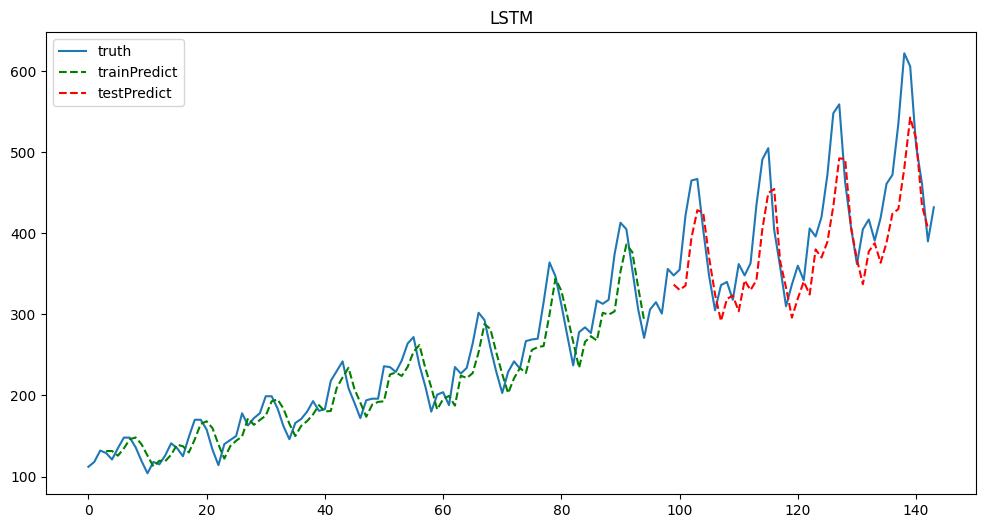

In [9]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(scaler.inverse_transform(dataset), label='truth');
ax.plot(trainPredictPlot, linestyle='--', color='green', label="trainPredict");
ax.plot(testPredictPlot, linestyle='--', color='red', label="testPredict"); 
ax.legend();
ax.set_title("LSTM")

### LSTM with Time Steps

In [10]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX[:2]

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]]], dtype=float32)

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
92/92 - 2s - loss: 0.0097 - 2s/epoch - 18ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0054 - 141ms/epoch - 2ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0048 - 148ms/epoch - 2ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0043 - 154ms/epoch - 2ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0039 - 152ms/epoch - 2ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0038 - 141ms/epoch - 2ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0037 - 143ms/epoch - 2ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0038 - 154ms/epoch - 2ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0035 - 126ms/epoch - 1ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0035 - 128ms/epoch - 1ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0036 - 147ms/epoch - 2ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0036 - 152ms/epoch - 2ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0035 - 150ms/epoch - 2ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0036 - 158ms/epoch - 2ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0035 - 155ms/epoch - 2ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0034 - 140ms/epoc

Text(0.5, 1.0, 'LSTM')

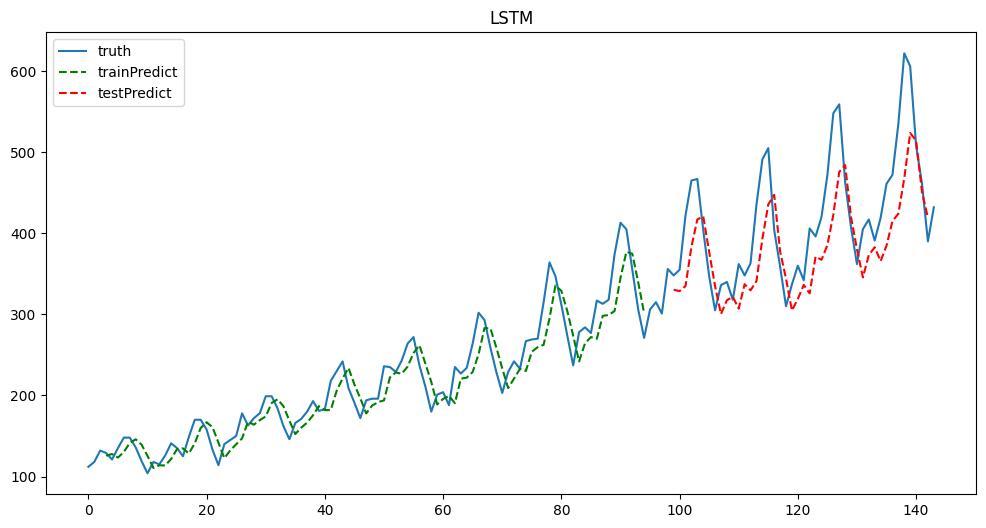

In [12]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(scaler.inverse_transform(dataset), label='truth');
ax.plot(trainPredictPlot, linestyle='--', color='green', label="trainPredict");
ax.plot(testPredictPlot, linestyle='--', color='red', label="testPredict"); 
ax.legend();
ax.set_title("LSTM")

### LSTM with Memory Between Batches

In [13]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX[:2]

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]]], dtype=float32)

In [14]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(LSTM(4, InputLayer(batch_shape=(batch_size, look_back, 1)), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

92/92 - 1s - loss: 0.0043 - 1s/epoch - 16ms/step
92/92 - 0s - loss: 0.0058 - 160ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0051 - 138ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0047 - 139ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0045 - 158ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0044 - 120ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0044 - 152ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0044 - 127ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0043 - 128ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0043 - 154ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0043 - 137ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0043 - 140ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0043 - 152ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 141ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 142ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 149ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 139ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 153ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0041 - 133ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0041 - 146ms

Text(0.5, 1.0, 'LSTM')

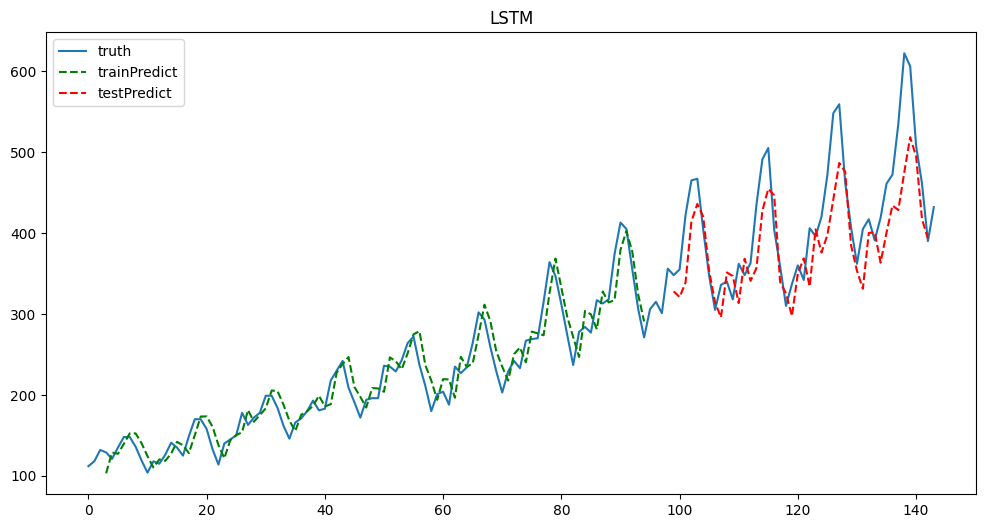

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(scaler.inverse_transform(dataset), label='truth');
ax.plot(trainPredictPlot, linestyle='--', color='green', label="trainPredict");
ax.plot(testPredictPlot, linestyle='--', color='red', label="testPredict"); 
ax.legend();
ax.set_title("LSTM")

### Stacked LSTMs with Memory Between Batches

In [16]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX[:2]

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]]], dtype=float32)

In [17]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

92/92 - 3s - loss: 0.0046 - 3s/epoch - 33ms/step
92/92 - 0s - loss: 0.0127 - 193ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0080 - 189ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0065 - 194ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0059 - 191ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 195ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0056 - 192ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0056 - 218ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0055 - 237ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0055 - 199ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0055 - 191ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0055 - 191ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0055 - 197ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0054 - 189ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0054 - 200ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0054 - 189ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0054 - 279ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0054 - 190ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0054 - 192ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0054 - 196ms

Text(0.5, 1.0, 'LSTM')

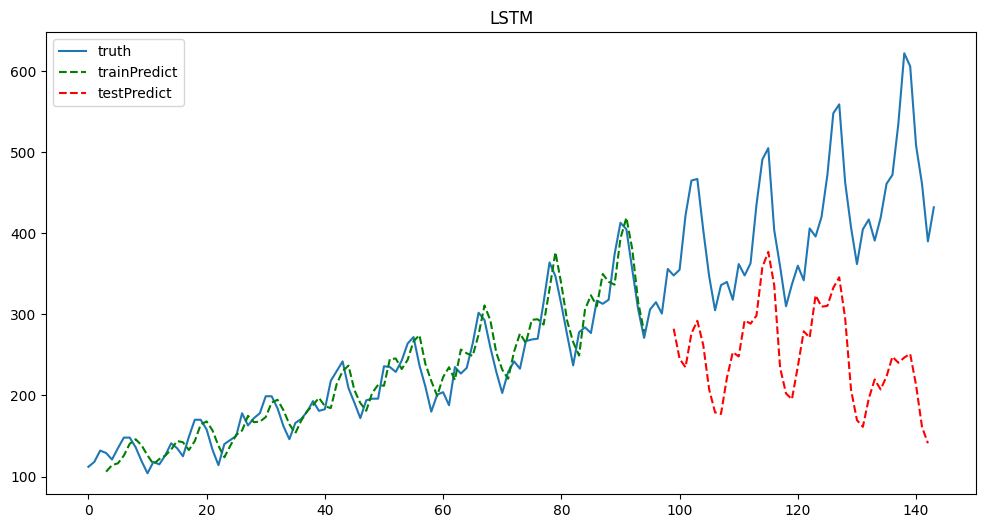

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(scaler.inverse_transform(dataset), label='truth');
ax.plot(trainPredictPlot, linestyle='--', color='green', label="trainPredict");
ax.plot(testPredictPlot, linestyle='--', color='red', label="testPredict"); 
ax.legend();
ax.set_title("LSTM")

### Prophet

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


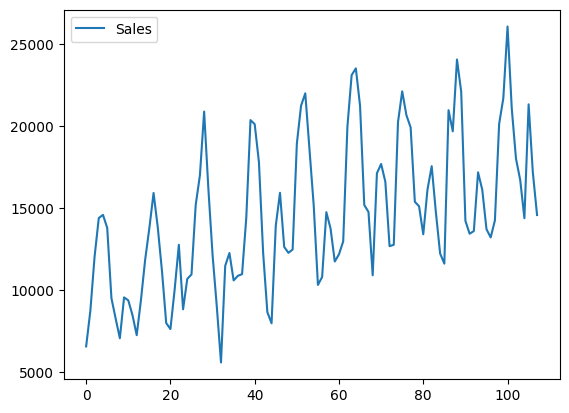

In [19]:
df = pd.read_csv('monthly-car-sales.csv', header=0)
# summarize shape
print(df.shape)
# show first few rows
print(df.head())
# plot the time series
df.plot()
plt.show()

In [20]:
# prepare expected column names
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(df)

20:36:54 - cmdstanpy - INFO - Chain [1] start processing
20:36:54 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14339.349014  12864.919790  15982.125086
1 1968-02-01  14909.646367  13238.844650  16417.973832
2 1968-03-01  20863.047351  19271.020755  22500.221444
3 1968-04-01  22881.375138  21519.060092  24509.210455
4 1968-05-01  24172.401917  22623.826088  25754.909760


/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


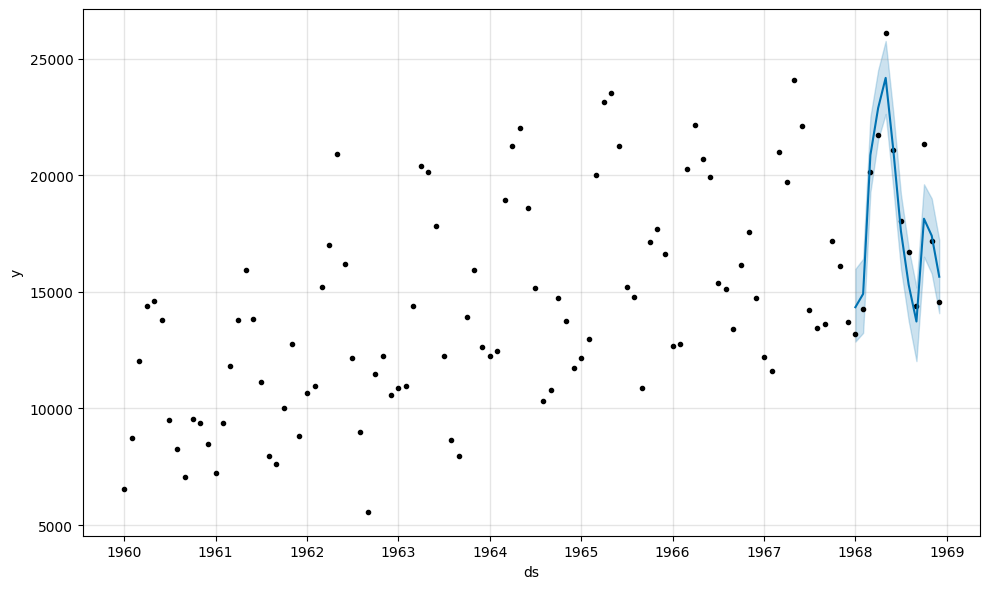

In [22]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '1968-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [23]:
# create test dataset, remove last 12 months
train = df.drop(df.index[-12:])
print(train.tail())
# define the model
model = Prophet()
# fit the model
model.fit(train)

20:38:20 - cmdstanpy - INFO - Chain [1] start processing


           ds      y
91 1967-08-01  13434
92 1967-09-01  13598
93 1967-10-01  17187
94 1967-11-01  16119
95 1967-12-01  13713


20:38:20 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '1968-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 1336.813


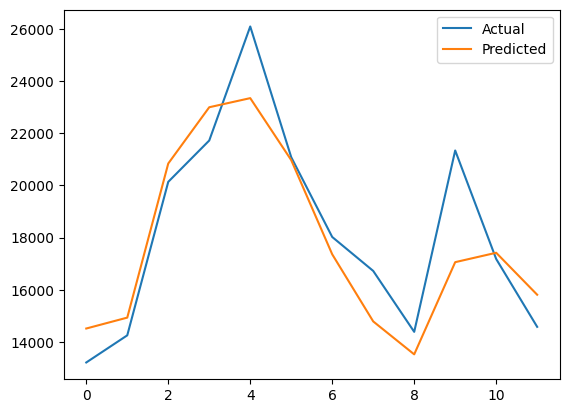

In [25]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()